# Лабораторная работа №4
Пресняцкий Виктор, гр. 956241, вариант 5

## Кластеризация самоорганизующимися сетью и картой Кохонена. Обучение без учителя.

Сгенерировать случайным образом множество 2-мерных точек на декартовой плоскости. Обучающее множество эталонных выходов отсутствует. Необходимо реализовать построение и обучение:
- сети Кохонена, которая распределяет входное множество точек на кластеры;
- карты Кохонена.

Вариант: прямоугольная 8-связная сеть, манхэттенское расстояние.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def generate_dataset(number_of_samples, low=-10, high=10):
    return np.random.uniform(low=low, high=high, size=(number_of_samples, 2))

In [4]:
X = generate_dataset(50)

In [5]:
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], color='g', s=10)
plt.show()

In [6]:
def normalize(X):
    X = X.copy().astype(np.float)
    if len(X.shape) == 1:
        return X / np.sqrt(np.sum(X ** 2))
    for i in range(X.shape[0]):
        X[i] = normalize(X[i])
    return X

In [7]:
class KohonenNetwork:
    EPS = 0.0001

    def __init__(self, num_of_clusters):
        self.num_of_clusters = num_of_clusters
        self.weights = None

    def fit(self, X, learning_rate=0.1):
        X = normalize(X)
        w = np.random.rand(self.num_of_clusters, 2)
        while 1:
            w_previous = np.copy(w)
            for x_i in X:
                y = np.dot(w, x_i)
                k = np.argmax(y)
                w[k] = normalize(w_previous[k] + learning_rate * (x_i - w_previous[k]))
        
            weights_diff = np.abs(w - w_previous)
            if weights_diff[weights_diff > self.EPS].size == 0:
                break

        self.weights = w

    def predict(self, X):
        if self.weights is None:
            raise Exception('Network is not trained: call `fit` method.')

        X = normalize(X)
        x_size = X.shape[0]
        clusters = np.zeros(x_size)
        for i in range(x_size):
            y = np.dot(self.weights, X[i])
            clusters[i] = np.argmax(y)
        return clusters

In [8]:
num_of_clusters = 4
kohonen_network = KohonenNetwork(num_of_clusters=num_of_clusters)
kohonen_network.fit(X)

In [9]:
clusters = kohonen_network.predict(X)

In [29]:
COLORS = ['b', 'g', 'r', 'm', 'c', 'y', 'k', 'peru', 'orange', 'brown', 'tan', 'olive', 'darkred', 'orangered', 'chocolate']

In [11]:
def plot_clusters(X, clusters, num_of_clusters, weights, test_size=None):
    if test_size is not None:
        x_test = generate_dataset(test_size)
        test_clusters = kohonen_network.predict(x_test)
        test_clusterized_dots = [np.where(test_clusters == j)[0] for j in range(num_of_clusters)]

    clusterized_dots = [np.where(clusters == i)[0] for i in range(num_of_clusters)]

    plt.figure(figsize=(8,8))
    for i in range(num_of_clusters):
        plt.scatter(X[clusterized_dots[i], 0], X[clusterized_dots[i], 1], marker='x', color=COLORS[i], label="Cluster " + str(i + 1))
        if test_size is not None:
            plt.scatter(x_test[test_clusterized_dots[i], 0], x_test[test_clusterized_dots[i], 1], marker='8', color=COLORS[i], s=80, label="Test cluster " + str(i + 1))
        else:
            plt.scatter(weights[i, 0], weights[i, 1], marker='8', color=COLORS[i], s=50, label="Norm centroid for cluster " + str(i + 1))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.show()

На следующем графике показаны кластеризованные точки и их нормализованные центройды.

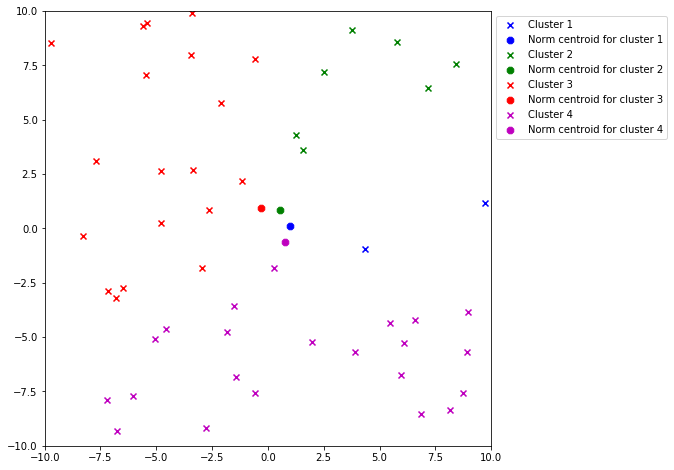

In [12]:
plot_clusters(X, clusters, kohonen_network.num_of_clusters, kohonen_network.weights)

Продемонстрируем, что тестовые точки попадают в правильные кластера.

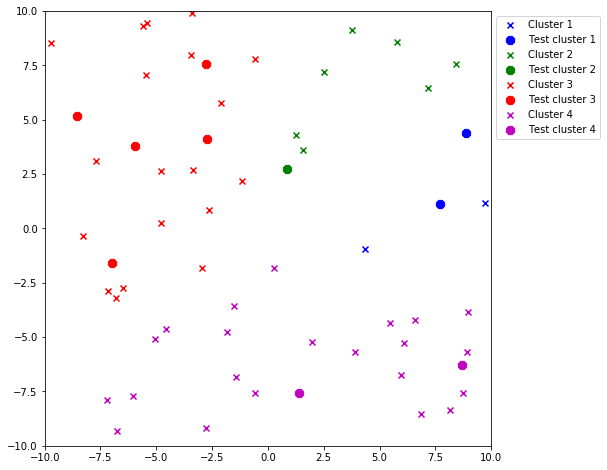

In [15]:
plot_clusters(X, clusters, kohonen_network.num_of_clusters, kohonen_network.weights, test_size=10)

#### Саморорганизующиеся карты Кохонена

In [16]:
class KohonenSOM:
    EPS = 0.0001
    
    def __init__(self, rows, cols):
        self.dim = (rows, cols)

    @staticmethod
    def manhattan_distance(a, b):
        return np.sum(np.abs(a - b))

    @staticmethod
    def g(distance):
        return np.exp(-(distance ** 2))

    def _calc_new_weight(self, w, x_i, lr):
        return normalize(w + lr * self.g(self.manhattan_distance(x_i, w)) * (x_i - w))

    def fit(self, X, learning_rate=1):
        X = normalize(X)
        w = np.random.rand(*self.dim, 2)

        while 1:
            w_previous = np.copy(w)
            for x_i in X:
                y = np.array([np.dot(w[i, j], x_i) for i in range(self.dim[0]) for j in range(self.dim[1])])
                k_index = np.unravel_index(np.argmax(y), self.dim)

                # обойти всех ближайших соседей
                x_indexes = set([max(k_index[0] - 1, 0), k_index[0], min(k_index[0] + 1, self.dim[0] - 1)])
                y_indexes = set([max(k_index[1] - 1, 0), k_index[1], min(k_index[1] + 1, self.dim[1] - 1)])
                for i in x_indexes:
                    for j in y_indexes:
                        w[i, j] = normalize(self._calc_new_weight(w[i, j], x_i, learning_rate))

            weights_diff = np.abs(w - w_previous)
            if weights_diff[weights_diff > self.EPS].size == 0:
                break

        self.weights = w

    def predict(self, X):
        X = normalize(X)
        x_size = X.shape[0]
        clusters = np.zeros(x_size)
        for k in range(X.shape[0]):
            y = np.array([np.dot(self.weights[i, j], X[k]) for i in range(self.dim[0]) for j in range(self.dim[1])])
            clusters[k] = np.argmax(y)
        return clusters

Обучаем сеть, строя 8-связную прямоугольную сетку 5х3. Точки соответственно будет разделены на 15 кластеров.

In [17]:
ROWS = 5
COLS = 3

X_som = generate_dataset(300, low=-30, high=30)
kohonen_som = KohonenSOM(rows=ROWS, cols=COLS)
kohonen_som.fit(X_som)

In [18]:
som_predictions = kohonen_som.predict(X_som)

In [19]:
def plot_som_clusters(X, preds, weights, rows, cols, test_size=None):
    if test_size is not None:
        X_som_test = generate_dataset(test_size, low=-30, high=30)
        test_som_clusters = kohonen_som.predict(X_som_test)
        test_clusterized_dots = [np.where(test_som_clusters == np.ravel_multi_index((i, j), (ROWS,COLS)))[0] for i in range(rows) for j in range(cols)]

    clusterized_dots = [np.where(preds == np.ravel_multi_index((i, j), (ROWS,COLS)))[0] for i in range(rows) for j in range(cols)]

    plt.figure(figsize=(12, 12))
    for i in range(rows * cols):
        ind = np.unravel_index(i, shape=(rows, cols))
        plt.scatter(X[clusterized_dots[i], 0], X[clusterized_dots[i], 1], marker='x', color=COLORS[i], s=30, label="Cluster " + str(i + 1))
        if test_size is not None:
            plt.scatter(X_som_test[test_clusterized_dots[i], 0], X_som_test[test_clusterized_dots[i], 1], marker='8', color=COLORS[i], s=80, label="Test cluster " + str(i + 1))
        else:
            plt.scatter(weights[ind][0], weights[ind][1], marker='8', color=COLORS[i], s=30, label="Norm centroid for cluster " + str(i + 1))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlim(-30, 30)
    plt.ylim(-30, 30)
    plt.show()

На следующем графике показаны кластеризованные точки и их нормализованные центройды.

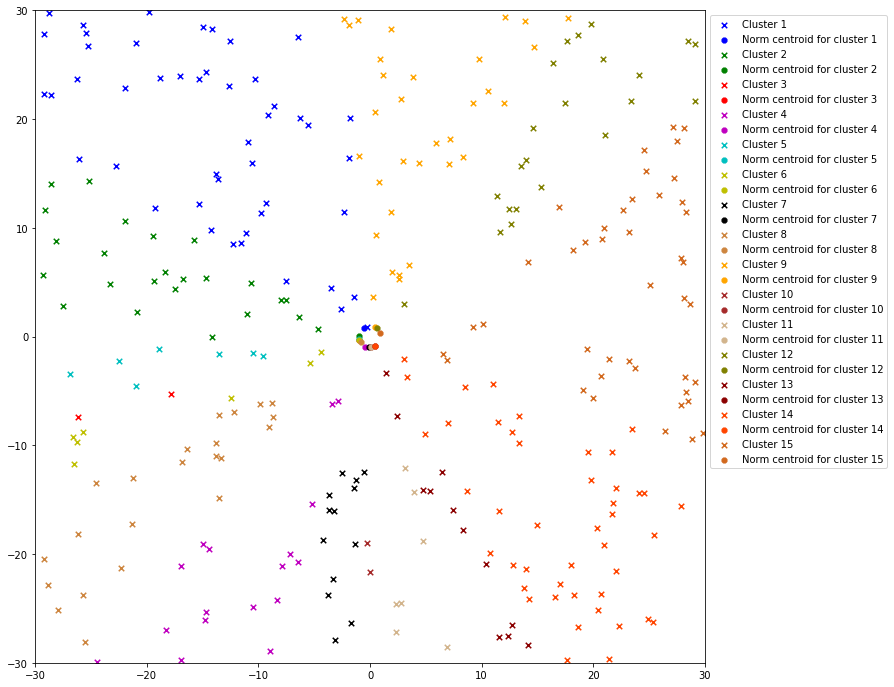

In [30]:
plot_som_clusters(X_som, som_predictions, kohonen_som.weights, *kohonen_som.dim)

Продемонстрируем, что тестовые точки попадают в правильные кластера.

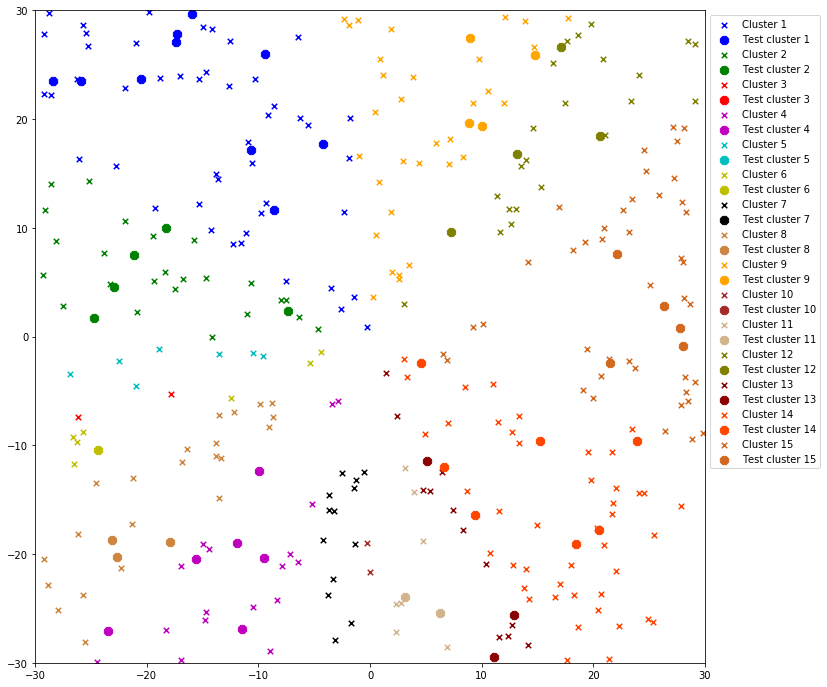

In [31]:
plot_som_clusters(X_som, som_predictions, kohonen_som.weights, *kohonen_som.dim, test_size=50)